<a href="https://colab.research.google.com/github/FariaParvinMegha/Electricity_fraud/blob/main/Electricity_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# setting up environment

In [1]:
!pip install tensorflow==2.18.0 keras==3.10.0 protobuf==5.29.1
!pip install -U imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 29.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0


In [2]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [3]:

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, confusion_matrix, precision_recall_fscore_support, roc_auc_score
from tensorflow import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, Conv1D, Flatten, Conv2D
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm

# Data Loading

In [4]:
from google.colab import drive
# drive.mount('/content/drive')
rawData = pd.read_csv('/content/drive/MyDrive/electricity fraud detection/data.csv')
# rawData = rawData.iloc[:, -30:]

In [5]:
rawData.columns

Index(['CONS_NO', 'FLAG', '2014/1/1', '2014/1/10', '2014/1/11', '2014/1/12',
       '2014/1/13', '2014/1/14', '2014/1/15', '2014/1/16',
       ...
       '2016/9/28', '2016/9/29', '2016/9/3', '2016/9/30', '2016/9/4',
       '2016/9/5', '2016/9/6', '2016/9/7', '2016/9/8', '2016/9/9'],
      dtype='object', length=1036)

# Data Preprocessing

In [6]:

# rawData = rawData.iloc[:, :2].join(rawData.iloc[:, -30:])
# rawData.columns.values[-30:] = [f"day{i}" for i in range(1, 31)]

# Extract label and ID columns
infoData = pd.DataFrame()
infoData['FLAG'] = rawData['FLAG']
infoData['CONS_NO'] = rawData['CONS_NO']
# Remove label and ID from feature data
data = rawData.drop(['FLAG', 'CONS_NO'], axis=1)

dropIndex = data[data.duplicated()].index  # duplicates drop
data = data.drop(dropIndex, axis=0)
infoData = infoData.drop(dropIndex, axis=0)

zeroIndex = data[(data.sum(axis=1) == 0)].index  # zero rows drop
data = data.drop(zeroIndex, axis=0)
infoData = infoData.drop(zeroIndex, axis=0)

# data.columns = pd.to_datetime(data.columns)  # columns reindexing according to dates
# data = data.reindex(sorted(data.columns), axis=1)
cols = data.columns

data.reset_index(inplace=True, drop=True)  # index sorting
infoData.reset_index(inplace=True, drop=True)

data = data.interpolate(method='linear', limit=2,  # filling NaN values
                        limit_direction='both', axis=0).fillna(0)

for i in range(data.shape[0]):  # outliers treatment
    m = data.loc[i].mean()
    st = data.loc[i].std()
    data.loc[i] = data.loc[i].mask(data.loc[i] > (m + 3 * st), other=m + 3 * st)

data.to_csv(r'visualization.csv', index=False, header=True)  # preprocessed data without scaling
# data.to_csv('/content/drive/MyDrive/python/visulaization.csv', index=False)

scale = MinMaxScaler()
scaled = scale.fit_transform(data.values.T).T
mData = pd.DataFrame(data=scaled, columns=data.columns)
# print(mData)
preprData = pd.concat([infoData, mData], axis=1, sort=False)  # Back to initial format
print(preprData)
# preprData.to_csv(r'preprocessedR.csv', index=False, header=True)
# preprData.to_csv('/content/drive/MyDrive/electricity fraud detection/preprocessed_data.csv', index=False, header=True)

       FLAG                           CONS_NO  2014/1/1  2014/1/10  2014/1/11  \
0         1  0387DD8A07E07FDA6271170F86AD9151  0.000000   0.000000   0.000000   
1         1  4B75AC4F2D8434CFF62DB64D0BB43103  0.108235   0.127642   0.142198   
2         1  B32AC8CC6D5D805AC053557AB05F5343  0.077443   0.091330   0.101744   
3         1  EDFC78B07BA2908B3395C4EB2304665E  0.111323   0.131284   0.146255   
4         1  6BCFD78138BC72A9BA1BFB0B79382192  0.141255   0.185367   0.199915   
...     ...                               ...       ...        ...        ...   
40251     0  F1472871E1AFF49D4289564B6377D76C  0.330066   0.272880   0.741561   
40252     0  F3C8BBCD2DC26C1E0249DEEF6A4256B7  0.275157   0.447385   0.402545   
40253     0  A9A0FE83467A680FBFB0DBFC910DF227  0.078565   0.113784   0.218086   
40254     0  D9A6ADA018FA46A55D5438370456AA45  0.417892   0.342429   0.334017   
40255     0  F3406636BAD1E6E0826E8EDDC9A1BF00  0.444454   0.364194   0.355247   

       2014/1/12  2014/1/13

# Data Balancing

In [7]:
# Drop the 'CONS_NO' column
preprData = preprData.drop('CONS_NO', axis=1)

# Apply SMOTE for data balancing
X = preprData.drop('FLAG', axis=1)  # Features
y = preprData['FLAG']  # Target (labels)

# Instantiate SMOTE to balance the minority class (FLAG = 1)
smote = SMOTE()

# Resampling the data to balance classes
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# class AdaBoostClassifierWithProgress(AdaBoostClassifier):
#     def fit(self, X, y):
#         self.n_estimators_ = self.n_estimators
#         self.staged_predict_proba_ = []
#         self.progress_bar = tqdm(total=self.n_estimators, desc="Training AdaBoost", ncols=100)

#         super().fit(X, y)

#         self.progress_bar.close()
#         return self

#     def _boost(self, iboost, X, y, sample_weight, random_state):
#         self.progress_bar.update(1)
#         return super()._boost(iboost, X, y, sample_weight, random_state)

# # Instantiate the customized AdaBoost classifier with progress tracking
# adaBoost = AdaBoostClassifierWithProgress(n_estimators=100, random_state=42)

# # Train the classifier on the balanced data
# adaBoost.fit(X_train, y_train)

# # Make predictions on the test data
# y_pred = adaBoost.predict(X_test)

# # Evaluate the classifier performance
# print(classification_report(y_test, y_pred))

# Combine the resampled data into a DataFrame
balancedData = pd.concat([pd.DataFrame(y_resampled, columns=['FLAG']), pd.DataFrame(X_resampled, columns=X.columns)], axis=1)

# Save the balanced data
balancedData.to_csv(r'balanced_preprocessedR.csv', index=False, header=True)
# balancedData.to_csv('/content/drive/MyDrive/electricity fraud detection/balanced_preprocessedR.csv', index=False, header=True)


# Model training

Parameters

In [8]:
tf.random.set_seed(1234)
epochs_number = 10  # number of epochs for the neural networks
test_set_size = 0.1  # percentage of the test size comparing to the whole dataset
oversampling_flag = 0  # set to 1 to over-sample the minority class
oversampling_percentage = 0.2  # percentage of the minority class after the oversampling comparing to majority class


In [9]:
# Definition of functions
def read_data():
    rawData = pd.read_csv('balanced_preprocessedR.csv')

    # Setting the target and dropping the unnecessary columns
    y = rawData[['FLAG']]
    X = rawData.drop(['FLAG'], axis=1)

    print('Normal Consumers:                    ', y[y['FLAG'] == 0].count()[0])
    print('Consumers with Fraud:                ', y[y['FLAG'] == 1].count()[0])
    print('Total Consumers:                     ', y.shape[0])
    print("Classification assuming no fraud:     %.2f" % (y[y['FLAG'] == 0].count()[0] / y.shape[0] * 100), "%")

    # columns reindexing according to dates
    # X.columns = pd.to_datetime(X.columns)
    # X = X.reindex(X.columns, axis=1)

    # Splitting the dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y['FLAG'], test_size=test_set_size, random_state=0)
    print("Test set assuming no fraud:           %.2f" % (y_test[y_test == 0].count() / y_test.shape[0] * 100), "%\n")

    return X_train, X_test, y_train, y_test

# Models

# ANN


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def ANN(X_train, X_test, y_train, y_test):
    print('Artificial Neural Network:')
    save_folder='/content/drive/MyDrive/electricity fraud detection/resultsImages'

    # ✅ Ensure proper array format
    X_train = np.asarray(X_train).astype(np.float32)
    X_test = np.asarray(X_test).astype(np.float32)
    y_train = np.asarray(y_train).astype(np.float32)
    y_test = np.asarray(y_test).astype(np.float32)

    # ✅ Reshape labels to match binary output
    if len(y_train.shape) == 1:
        y_train = y_train.reshape(-1, 1)
    if len(y_test.shape) == 1:
        y_test = y_test.reshape(-1, 1)

    # ✅ Check input shape
    input_dim = X_train.shape[1]

    # ✅ Build model
    model = Sequential()
    model.add(Dense(1000, input_dim=input_dim, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss=keras.losses.binary_crossentropy, optimizer='adam', metrics=['accuracy'])


    # ✅ Train model
    history = model.fit(
        X_train,
        y_train,
        validation_split=0.1,
        epochs=epochs_number,
        shuffle=True,
        verbose=1
    )

    # ✅ Predict and evaluate
    prediction = (model.predict(X_test) > 0.5).astype("int32")
    model.summary()

    # ✅ Call results function
    results(y_test, prediction, history = history, model=model, model_name = 'ANN', save_folder = save_folder)

# 1D CNN

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense
from tensorflow.keras import losses
import numpy as np

def CNN1D(X_train, X_test, y_train, y_test, epochs_number=10):
    print('1D - Convolutional Neural Network:')
    save_folder='/content/drive/MyDrive/electricity fraud detection/resultsImages'

    # Convert to numpy arrays if needed
    if hasattr(X_train, "to_numpy"):
        X_train = X_train.to_numpy()
    if hasattr(X_test, "to_numpy"):
        X_test = X_test.to_numpy()

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1).astype(np.float32)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1).astype(np.float32)

    y_train = np.asarray(y_train).astype(np.float32).reshape(-1, 1)
    y_test = np.asarray(y_test).astype(np.float32).reshape(-1, 1)

    # Model definition
    model = Sequential()
    model.add(Conv1D(100, kernel_size=7, input_shape=(X_train.shape[1], 1), activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # ✅ Fit model and capture history
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs_number,
        validation_split=0.1,
        shuffle=True,
        verbose=1
    )

    # ✅ Make predictions
    prediction = (model.predict(X_test) > 0.5).astype("int32")

    # saving the model
    # ✅ Evaluate using shared results() function
    results(
        y_test=y_test,
        prediction=prediction,
        history=history,
        model=model,
        model_name='CNN1D',
        save_folder=save_folder
    )
    model.summary()
    return model


# 2D CNN

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
import numpy as np
def CNN2D(X_train, X_test, y_train, y_test):
    print('2D - Convolutional Neural Network:')
    save_folder='/content/drive/MyDrive/electricity fraud detection/resultsImages'

    # Transforming every row of the train set into a 2D array and then into a tensor
    n_array_X_train = X_train.to_numpy()
    n_array_X_train_extended = np.hstack((n_array_X_train, np.zeros(
        (n_array_X_train.shape[0], 2))))  # adding two empty columns in order to make the number of columns
    # an exact multiple of 7
    week = []
    for i in range(n_array_X_train_extended.shape[0]):
        a = np.reshape(n_array_X_train_extended[i], (-1, 7, 1))
        week.append(a)
    X_train_reshaped = np.array(week)

    # Transforming every row of the train set into a 2D array and then into a tensor
    n_array_X_test = X_test.to_numpy()  # X_test to 2D - array
    n_array_X_train_extended = np.hstack((n_array_X_test, np.zeros((n_array_X_test.shape[0], 2))))
    week2 = []
    for i in range(n_array_X_train_extended.shape[0]):
        b = np.reshape(n_array_X_train_extended[i], (-1, 7, 1))
        week2.append(b)
    X_test_reshaped = np.array(week2)

    input_shape = (1, 148, 7, 1)  # input shape of the tensor

    # Model creation
    model = Sequential()
    model.add(Conv2D(kernel_size=(7, 3), filters=32, input_shape=input_shape[1:], activation='relu',
                     data_format='channels_last'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])

    # Fit model and track history
    history = model.fit(
        X_train_reshaped,
        y_train,
        validation_split=0.1,
        epochs=epochs_number,
        shuffle=True,
        verbose=1
    )

    # Predict and reshape
    prediction = (model.predict(X_test_reshaped) > 0.5).astype("int32")
    model.summary()

    # saving the model
    # Evaluate using results() with history
    results(
        y_test=y_test,
        prediction=prediction,
        history=history,
        model=model,
        model_name='CNN2D',
        save_folder=save_folder
    )

    return model

# Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import joblib
def LR(X_train, X_test, y_train, y_test):
    print('Logistic Regression:')
    save_folder='/content/drive/MyDrive/electricity fraud detection/resultsImages'
    '''
    # Parameters selection
    param_grid = {'C': [0.1,1,10,100],'solver': ['newton-cg', 'lbfgs']}
    grid = GridSearchCV(LogisticRegression(max_iter=1000,random_state=0), param_grid=param_grid, n_jobs=-1)
    grid.fit(X_train, y_train)
    df = pd.DataFrame(grid.cv_results_)
    print(df[['param_C', 'param_solver', 'mean_test_score', 'rank_test_score']])
    '''
    model = LogisticRegression(C=1000, max_iter=1000, n_jobs=-1, solver='newton-cg')
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    # saving the model
    results(y_test, prediction, model = model, model_name = 'LR', save_folder=save_folder)

# decision Tree

In [44]:
from sklearn.tree import DecisionTreeClassifier
import joblib
def DT(X_train, X_test, y_train, y_test):
    print('Decision Tree:')
    save_folder='/content/drive/MyDrive/electricity fraud detection/resultsImages'
    model = DecisionTreeClassifier(max_depth=15, min_samples_split=10, random_state=0)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    # saving the model
    results(y_test, prediction, model = model, model_name = 'DT', save_folder=save_folder)

# Random forest

In [47]:
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, precision_recall_fscore_support, roc_auc_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
def RF(X_train, X_test, y_train, y_test):
    save_folder='/content/drive/MyDrive/electricity fraud detection/resultsImages'
    # Reduce dimensionality with PCA (adjust n_components based on your dataset)
    pca = PCA(n_components=10)  # Change n_components to fit your data
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Parameter grid for RandomizedSearchCV
    param_dist = {
        'n_estimators': [50, 100],               # Fewer trees for faster performance
        'max_depth': [5, 10, None],              # Limit tree depth
        'min_samples_split': [2, 10],            # Minimum samples to split a node
        'min_samples_leaf': [1, 5],              # Minimum samples at a leaf node
        'max_features': ['sqrt', 'log2']         # Use 'sqrt' or 'log2' for feature selection
    }

    # Instantiate the RandomForestClassifier
    model = RandomForestClassifier(random_state=0, n_jobs=-1)

    # Use RandomizedSearchCV to tune hyperparameters quickly
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=3, random_state=0, n_jobs=-1)
    random_search.fit(X_train_pca, y_train)

    # Get the best estimator
    best_model = random_search.best_estimator_

    # Train the model with the best hyperparameters
    best_model.fit(X_train_pca, y_train)

    # Predict using the test data
    prediction = best_model.predict(X_test_pca)
    # Evaluate the results using the results function
    results(y_test, prediction, model = best_model, model_name = 'RF', save_folder=save_folder)

    # Return the best model
    return best_model

# XGBoost

In [50]:
import joblib
from xgboost import XGBClassifier
def XGB(X_train, X_test, y_train, y_test):
    save_folder='/content/drive/MyDrive/electricity fraud detection/resultsImages'
    # declare parameters
    params = {
                'objective':'binary:logistic',
                'max_depth': 4,
                'alpha': 10,
                'learning_rate': 1.0,
                'n_estimators':100
            }
    # instantiate the classifier
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    results(y_test, prediction, model = model, model_name = 'XGB', save_folder=save_folder)

    return model
# fit the classifier to the training data
# xgb_clf.fit(X_train, y_train)

# Results

# old results

In [26]:
import os  # Importing os to handle folder paths

def results(y_test, prediction, save_folder=None):
    # Calculate metrics
    accuracy = 100 * accuracy_score(y_test, prediction)
    rmse = mean_squared_error(y_test, prediction, squared=False)
    mae = mean_absolute_error(y_test, prediction)
    f1 = 100 * precision_recall_fscore_support(y_test, prediction, average='weighted')[2]  # Weighted F1 score
    auc = 100 * roc_auc_score(y_test, prediction)

    # Print metrics
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"F1 Score (Weighted): {f1:.2f}%")
    print(f"AUC: {auc:.2f}%")

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, prediction)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})

    # Add labels to the plot
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.title('Confusion Matrix', fontsize=16)

    # Ensure the plot is displayed properly
    plt.xticks(ticks=[0.5, 1.5], labels=['Normal (0)', 'Fraud (1)'], fontsize=12)
    plt.yticks(ticks=[0.5, 1.5], labels=['Normal (0)', 'Fraud (1)'], fontsize=12, rotation=0)

    # Save the confusion matrix plot as a PDF
    if save_folder is not None:
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
        cm_pdf_path = os.path.join(save_folder, 'confusion_matrix.pdf')
        plt.savefig(cm_pdf_path, format='pdf')

    plt.show()

    # Bar plot for the metrics
    metrics = ['Accuracy', 'RMSE', 'MAE', 'F1 Score', 'AUC']
    values = [accuracy, rmse, mae, f1, auc]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=metrics, y=values, palette='viridis')

    # Add value labels on top of the bars
    for i, value in enumerate(values):
        plt.text(i, value + 1, f'{value:.2f}', ha='center', fontsize=12)

    plt.title('Model Performance Metrics', fontsize=16)
    plt.ylabel('Value', fontsize=14)
    plt.ylim(0, max(values) + 5)  # Adjust ylim for better visualization

    # Save the bar plot as a PDF
    if save_folder is not None:
        bar_pdf_path = os.path.join(save_folder, 'model_performance_metrics.pdf')
        plt.savefig(bar_pdf_path, format='pdf')

    plt.show()

# better looking result images

In [51]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import (
    accuracy_score, mean_squared_error, mean_absolute_error,
    precision_recall_fscore_support, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
)

def results(y_test, prediction, history=None, model=None, model_name=None, save_folder=None):
    # Compute metrics
    accuracy = 100 * accuracy_score(y_test, prediction)
    loss = history.history['loss'][-1] if history else None
    rmse = mean_squared_error(y_test, prediction) ** 0.5
    mae = mean_absolute_error(y_test, prediction)
    f1 = 100 * precision_recall_fscore_support(y_test, prediction, average='weighted')[2]
    auc = 100 * roc_auc_score(y_test, prediction)

    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Loss: {loss:.4f}" if loss is not None else "Loss: N/A")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"F1 Score (Weighted): {f1:.2f}%")
    print(f"AUC: {auc:.2f}%")

    if save_folder:
        os.makedirs(save_folder, exist_ok=True)

        # ➤ Save metrics to .txt
        with open(os.path.join(save_folder, f"{model_name}_metrics.txt"), "w") as f:
            f.write(f"Accuracy: {accuracy:.2f}%\n")
            f.write(f"Loss: {loss:.4f}\n" if loss is not None else "Loss: N/A\n")
            f.write(f"RMSE: {rmse:.4f}\n")
            f.write(f"MAE: {mae:.4f}\n")
            f.write(f"F1 Score: {f1:.2f}%\n")
            f.write(f"AUC: {auc:.2f}%\n\n")
            f.write("Classification Report:\n")
            f.write(classification_report(y_test, prediction))

        # ➤ Save the model appropriately
        if model is not None:
            try:
                # Try saving Keras model
                model.save(os.path.join(save_folder, f"{model_name}.h5"))
            except AttributeError:
                # Fall back to sklearn via joblib
                joblib.dump(model, os.path.join(save_folder, f"{model_name}.pkl"))

    # ➤ Confusion Matrix
    cm = confusion_matrix(y_test, prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal (0)', 'Fraud (1)'])
    fig, ax = plt.subplots(figsize=(5, 4))
    disp.plot(cmap='Blues', ax=ax, colorbar=True, values_format='.2f')
    ax.set_title('Confusion Matrix', fontsize=14)
    ax.set_xlabel('Predicted Label', fontsize=13)
    ax.set_ylabel('True Label', fontsize=13)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    if save_folder:
        plt.savefig(os.path.join(save_folder, 'confusion_matrix.png'), dpi=150, bbox_inches='tight')
    plt.show()

    # ➤ Accuracy vs Epoch
    if history:
        plt.figure(figsize=(5, 4))
        plt.plot(history.history['accuracy'], marker='o', color='green', label='Accuracy')
        plt.xlabel('Epochs', fontsize=13)
        plt.ylabel('Accuracy', fontsize=13)
        plt.title('Accuracy vs Epoch', fontsize=14)
        plt.grid(True)
        plt.legend()
        if save_folder:
            plt.savefig(os.path.join(save_folder, 'accuracy_vs_epoch.png'), dpi=150, bbox_inches='tight')
        plt.show()

    # ➤ ROC Curve
    fpr, tpr, _ = roc_curve(y_test, prediction)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}%', color='darkorange')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.ylabel('True Positive Rate', fontsize=13)
    plt.title('ROC Curve', fontsize=14)
    plt.grid(True)
    plt.legend()
    if save_folder:
        plt.savefig(os.path.join(save_folder, 'roc_curve.png'), dpi=150, bbox_inches='tight')
    plt.show()

    # ➤ Bar Plot of All Metrics
    metric_names = ['Accuracy', 'Loss', 'RMSE', 'MAE', 'F1 Score', 'AUC']
    metric_vals = [accuracy, loss if loss else 0, rmse, mae, f1, auc]

    plt.figure(figsize=(6, 4))
    sns.barplot(x=metric_names, y=metric_vals, palette='crest')
    for i, val in enumerate(metric_vals):
        plt.text(i, val + 0.5, f'{val:.2f}', ha='center', fontsize=11)
    plt.title('Evaluation Metrics', fontsize=14)
    plt.ylabel('Value', fontsize=13)
    plt.xticks(rotation=30, fontsize=11)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    if save_folder:
        plt.savefig(os.path.join(save_folder, 'evaluation_metrics.png'), dpi=150, bbox_inches='tight')
    plt.show()



# Main

/tmp/ipython-input-9-1408516492.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Normal Consumers:                    ', y[y['FLAG'] == 0].count()[0])
/tmp/ipython-input-9-1408516492.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Consumers with Fraud:                ', y[y['FLAG'] == 1].count()[0])
/tmp/ipython-input-9-1408516492.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Classification assumi

Normal Consumers:                     36677
Consumers with Fraud:                 36677
Total Consumers:                      73354
Classification assuming no fraud:     50.00 %
Test set assuming no fraud:           49.39 %

Accuracy: 92.15%
Loss: N/A
RMSE: 0.2802
MAE: 0.0785
F1 Score (Weighted): 92.14%
AUC: 92.13%


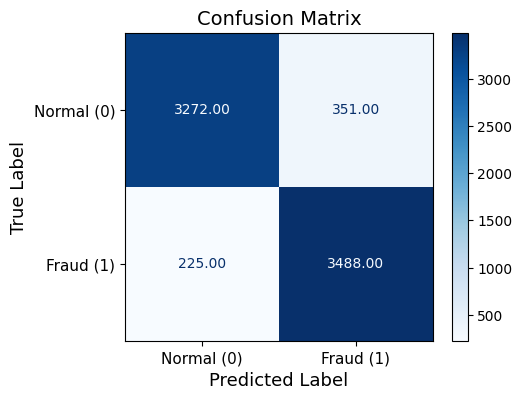

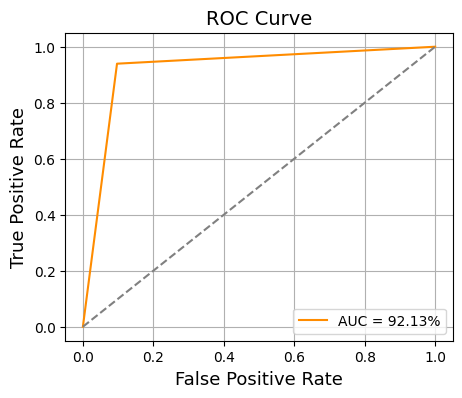

/tmp/ipython-input-51-2665843336.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric_names, y=metric_vals, palette='crest')


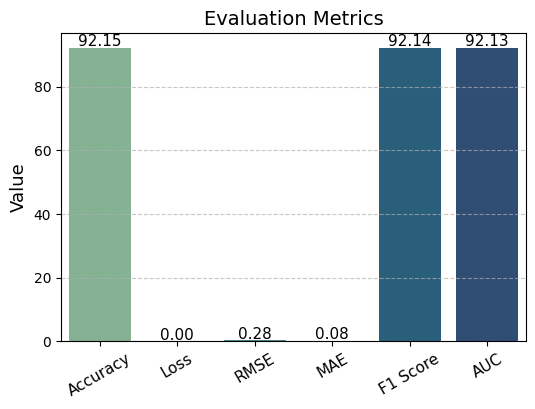

In [53]:

# ----Main----
X_train, X_test, y_train, y_test = read_data()

# Uncomment any model to test
# ANN(X_train, X_test, y_train, y_test)
# model = CNN1D(X_train, X_test, y_train, y_test)
# model = CNN2D(X_train, X_test, y_train, y_test)
# LR(X_train, X_test, y_train, y_test)
# DT(X_train, X_test, y_train, y_test)
# RF(X_train, X_test, y_train, y_test)
model = XGB(X_train, X_test, y_train, y_test)
# SVM(X_train, X_test, y_train, y_test)


# New Section